# Introduction

The aim of this task is to identify five lower super output areas (LSOA's) in the city of liverpool that will most benefit from Economic Development funding. 

The project aims to combine rigorous quantitative analysis with reasoned and intuative argument. Deploying a range of analytical techniques and a clear visulisation of results in order to offer strong justification for the selection of the most suitible areas to direct funding, high priority areas are defined as areas that can be shown to be both disadvantaged as well as popular. 

In [286]:
#Plot inline
%matplotlib inline

##import relevant modules 
import xml.dom.minidom
import seaborn as sns
import pandas as pd
from pysal.viz import mapclassify
from pysal.lib import weights
from pysal.lib.io import open as psopen
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pysal.explore import esda
from pysal.viz.splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
from sklearn import cluster
from shapely.geometry import Point
from geopandas import GeoDataFrame
from sklearn.cluster import dbscan
import matplotlib.patches as mpatches
import random
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Analysis - Disadvantage

The terms "Disadvantaged" and "Popular" are quite vague, so we will work with three different data sets in order to explore these terms in a more concrete manner. The first is the CDRC 2016 Access to Healthy Assets & Hazards index (AHAH) [1] This data contains AHAH index scores for all LSOA's in the liverpool city region with the index being a measure of accessibility to health promoting aspects within the local area, combining indicators from three domains; access to health services, the retail environment and the natural environment. A lower AHAH index suggets a greater accessbility to health promoting aspects. 


In [287]:
#import liverpool LSOA's shaepfile,this is taken from AHAH data.
AHAH_shp = gpd.read_file("Health/shapefiles/E08000012.shp")
#import AHAH index table data
AHAH_csv = pd.read_csv("Health/tables/E08000012.csv")
# Merge these 2 data sets by LSOA
AHAH = AHAH_shp.merge(AHAH_csv, on = "lsoa11cd")


To identify possible areas of disadvantage we need a way to measure the distribution of the AHAH index values accross the city. For this we can use Local Indicators of Spatial Association (LISAs). This offers a classification of the observations into four quadtrants: high values surrounded by high (HH), low values surrounded by low (LL), high values around low(HL) and viceversa (LH). LISA's not only do this but also determine wether a given cluster is statistically significant therefore locating certain areas that could be of genuine interest, these results are best visualised as a cluster map showing significant observations.

In [288]:
#create queen congiguity weights
w = weights.Queen.from_dataframe(AHAH, idVariable='lsoa11cd')

#calculate LISA values
lisa = esda.Moran_Local(AHAH['ahah'], w)

AHAH is only one possible measure of disadavntage, and it may be subject to some biases and irregular topology of the polygon layer into which the data is divided i.e. The modifiable areal unit problem as the boundaries are fairly arbitrary. To address this we will look at another dataset providing a possible measure , "The ASB Incidents, Crime and Outcomes" [2] data from 08/2019 - 10/2019, providing records of crimes committed and their locations. Using the DBSCAN algorithm we can generate clusters of points based on their density accross space, this wont suffer from the MAUP. For this case a cluster is a concentration of at least 250 points (locations of a crime) each of them within a distance of 500m of another point in the cluster, these clusters can then be mapped, along with the LISA for AHAH.

It should be noted that the DBSCAN algorithm is sensitive to changes in the parameters so may not always produce optimal clusters.

In [289]:
#import crime data for last 3 months 
crime1 = pd.read_csv("Crime_stats/2019-10/2019-10-merseyside-street.csv")
crime2 = pd.read_csv("Crime_stats/2019-09/2019-09-merseyside-street.csv")
crime3 = pd.read_csv("Crime_stats/2019-08/2019-08-merseyside-street.csv")

#as these dataframes all share the same columns we can stack them to from one frame
crime = pd.concat([crime1, crime2, crime3], axis=0)

#Now convert to geodataframe
#Convert lat + long to shapeley geometry
geometry = [Point(xy) for xy in zip(crime.Longitude, crime.Latitude)]
#remove lat+long columns from crime data frame
df = crime.drop(['Longitude', 'Latitude'], axis=1)
#convert to GeoDataFrame with point geometry included
crime = GeoDataFrame(df, crs = {'init': 'epsg:4326'}, geometry=geometry)
#set crs to british national grid to match other data
crime = crime.to_crs(epsg = 27700)

#create boundary polygon for liverpool city
boundary = AHAH.unary_union
#clip crime points to liverpool boundary as not all points currently fall in liverpool
crime = crime[crime.geometry.intersects(boundary)]

In [290]:
#get x and y co-ords from crime data, retaining same indexing
coords = pd.DataFrame({'X':crime.geometry.x, 'Y':crime.geometry.y}, index = crime.index) 

#create clusters using DBSCAN algorithm
cs, lbls = dbscan(coords[["X","Y"]], min_samples= 250, eps = 500)

#create series object from cluster labels, index the same was as the original dataset
lbls = pd.Series(lbls, index=crime.index)

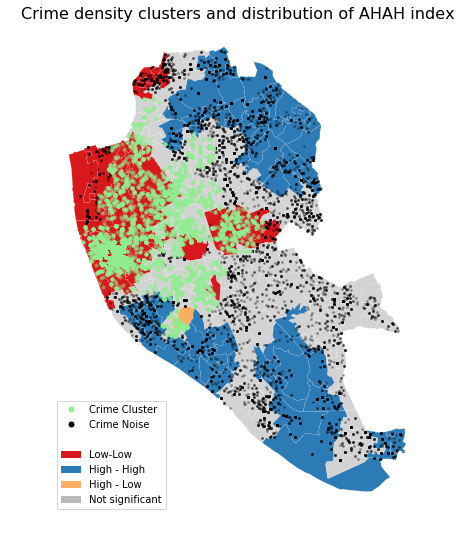

In [291]:

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# points from DBSCAN that are classed as noise are labelled -1 by the dbscan algorithm so subset these
noise = coords.loc[lbls==-1, ['X', 'Y']]

#Plot lisa
lisa_cluster(lisa, AHAH, ax= ax, alpha = 1,legend_kwds={'loc' : "best"}, legend = True);

# plot noise points from DBSCAN in grey
ax.scatter(noise['X'], noise['Y'], c='black', s=7, linewidth=0, alpha = 0.4)

#   Plot all points from DBSCAN that are not noise in red
#   This is done by removing all the poise that are noise from the full set of points, then plotting
ax.scatter(coords.loc[coords.index.difference(noise.index), 'X'], \
           coords.loc[coords.index.difference(noise.index), 'Y'], \
          c='lightgreen', linewidth=0, alpha = 0.5, s = 17)


#create custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Crime Cluster', #crime cluster markers
                          markerfacecolor='lightgreen', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='Crime Noise',
                          markerfacecolor='black', markersize=7),
                   Line2D([0], [0], marker='o', color='white', label='',
                          markerfacecolor='white', markersize=5),
                   Patch(facecolor='#d7191c',
                         label='Low-Low'),Patch(facecolor='#2c7bb6',         #LISA markers
                         label='High - High'),Patch(facecolor='#fdae61',
                         label='High - Low'),Patch(facecolor='#bababa',
                         label='Not significant')]

#show legend with the custom elements just created
ax.legend(handles=legend_elements, loc='best', facecolor = "white")
#Set title
ax.set_title("Crime density clusters and distribution of AHAH index", fontsize = 16)
#set background colour
f.set_facecolor('1')
#remove axis
ax.set_axis_off()
# Display the figure
plt.show()

It is notable here that clusters, created by the LISA, of areas with high AHAH index happen to share similar geography to clusters of high crime density from the DBSCAN, these areas tend to be in the north-east of the city
. Suggesting the are areas of disadvantage based on these measures, that may be suitible for funding.

# Analysis - Popularity

The first dataset used in order to determine popularity is the House transactions for Liverpool [3] data containing information on house sale transations and their locations. The distribution of this point data can be assesed using a Kernel Density Estimation which gets around the MAUP. The KDE allows us to view the continuous probability distribution of the data accross space.

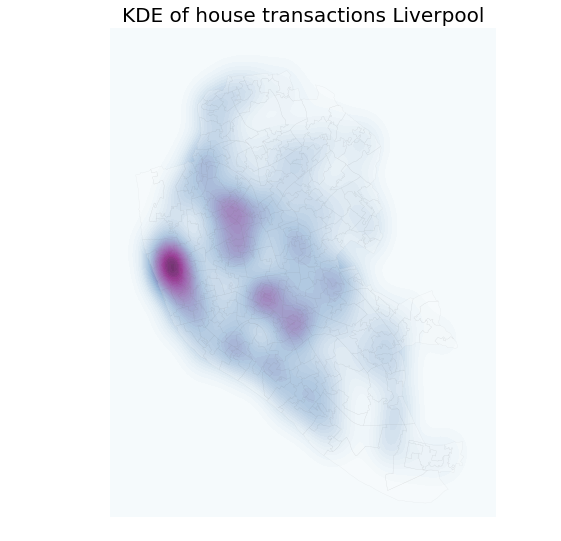

In [292]:
#Import house transaction data
house_shp = gpd.read_file("house_transactions/liv_house_trans.shp")

# Set up figure and axes
f, ax = plt.subplots(1, figsize=(9,9))
# generate a KDE
sns.kdeplot(house_shp.geometry.x, house_shp.geometry.y, ax=ax, \
            n_levels=50, shade=True, cmap='BuPu', legend = True)

#add a base layer with area geography (from AHAH shp)
AHAH.plot(ax=ax, facecolor='white', alpha=0.2, linewidth=0.2, edgecolor = "grey")
# remove axes
ax.set_axis_off()
# add a title
ax.set_title("KDE of house transactions Liverpool", fontsize = 20)
# keep axes equal
plt.axis('equal')
# Draw 
plt.show()



From the KDE plot certain areas of high activity in house transactions can be seen. The distibution here tends to be concentrated around the East/North-East region. Suggesting possible areas of high popularity.

# LSOA selection

The previous analysis has provided a solid understanding of the main areas of interest based on the given measures used. It is required that specifically 5 LSOA's are identified for funding. To do this, attributes from the previous datasets can be combined and K-means clustering used to determine similar LSOA's across measures of both disadvantage and popularity. The aim of the K-means is to group LSOA's based on crime counts, house transactions and AHAH index. 

In [293]:


# Aggregate crime numbers by LSOA and create data frame
crime_counts = pd.DataFrame({'LSOA':crime["LSOA code"].value_counts().index,
                             'Crimes':crime["LSOA code"].value_counts()}).reset_index(drop = True)

#aggregate house transaction numbers by LSOA and creade data frame
house_counts = pd.DataFrame({'LSOA':house_shp["LSOA11CD"].value_counts().index,
                             'House transactions':house_shp["LSOA11CD"].value_counts()}).reset_index(drop = True)


#refine AHAH to get only ahah index, geometry and LSOA code, no aggregation needed as this is already seperated by LSOA
AHAH_index = GeoDataFrame({'LSOA':AHAH.lsoa11cd, 'AHAH':AHAH.ahah, "geometry" : AHAH.geometry}).reset_index(drop = True)

#Merge the 3 frames, making sure to merge with the geodata frame on the left, this ensures the outcome is a geodata frame
merged = pd.merge(AHAH_index,house_counts,on = ["LSOA","LSOA"])
merged = pd.merge(merged,crime_counts,on = ["LSOA","LSOA"])



In [294]:
#log-transform the features we want to use for K-means clustering as some of them are highly skewed in distribution which is not optimal for k means 
features = np.log(merged[["AHAH","House transactions","Crimes"]])


#Define k-means paramteres, i.e. number of clusters 
np.random.seed(123)
kmeans = cluster.KMeans(n_clusters= 15)

#apply k-means algorithm to feature set
kcls = kmeans.fit(features)

#add cluster labels to data sets
features['kcls'] = kcls.labels_
merged['kcls'] = kcls.labels_

#Get mean of attribute values for each cluster
means = features.groupby('kcls').mean()

#create column containg sum of mean feature values for the cluster, as higher value is desirable for all features
means['Sum'] = means['Crimes'] + means['House transactions'] + means['AHAH']

#get clusters with top summed values
means.sort_values(by = ["Sum"],ascending=False)[0:2]

,AHAH,House transactions,Crimes,Sum
kcls,,,,
13,3.921725,2.639057,7.006695,13.567477
2,3.694130,4.238608,5.603002,13.535740


A log transformation was applied to the attributes before clustering due to highly skewd data, then 15 clusters were identified. Given that for our purpose high values are desirable for all attributes, the mean attribute scores for each cluster was summed then the 2 clusters with the highest summed value were selected. This gave 7 LSOA's in total, from this the 5 LSOA's best matching the previously determined areas of interest were selected.

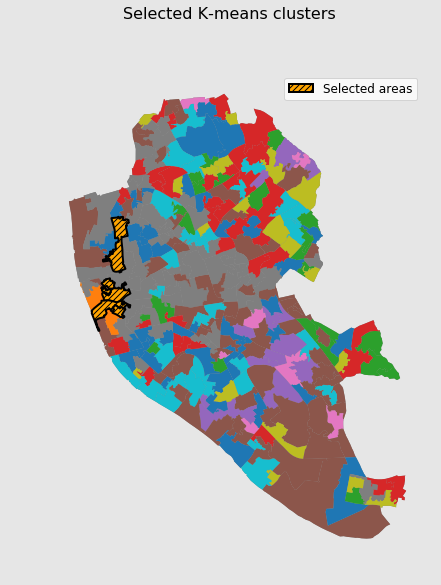

In [324]:
#make figure
f, ax = plt.subplots(1, figsize=(9, 9))
#add base geography
AHAH.plot(ax=ax, facecolor='grey', alpha=1, linewidth=0.7)

#Plot k-means clusters
merged.plot(column='kcls', categorical=True, legend=True, linewidth=0, ax=ax)
#highlight selected areas from the 2 selected k-means clusters
merged[merged.kcls  == 13].plot(ax = ax, color = "orange", edgecolor = "black", linewidth = 2,hatch = '////')
merged[merged.kcls  == 2][2:6].plot(ax = ax, color = "orange", edgecolor = "black",linewidth = 2, hatch = '////')

#set symbol and label for legend
orange_patch = mpatches.Patch(facecolor='orange', label='Selected areas',edgecolor = "black", linewidth = 2,hatch = '////')
#create legend
ax.legend(handles=[orange_patch], fontsize = 12)

#remove axis
ax.set_axis_off()

# Change background color of the figure
f.set_facecolor('0.9')
# Title
f.suptitle('Selected K-means clusters' , size=16)
# Draw
plt.show()

In [311]:
#Print selected areas, as shown in the above map

print("Choices Areas are" ,list(merged[merged.kcls  == 13].LSOA) + list(merged[merged.kcls  == 2][2:6].LSOA ))

Choices Areas are ['E01033760', 'E01033756', 'E01033761', 'E01033762', 'E01033764']


The final choice of LSOA's as mapped above are (E01033760, E01033756, E01033761, E01033762, E01033764)

# References

[1] Data provided by the ESRC Consumer Data Research Centre; Contains LDC data 2016; Contains CDRC data 2016;

[2] https://data.police.uk/data/

[3]Contains HM Land Registry data © Crown copyright and database right 2019. This data is licensed under the Open Government Licence v3.0. 

